In [10]:
import torch
from torch import nn
from torchvision.datasets import MNIST, SVHN
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

In [2]:
transform = T.Compose([T.ToTensor(), T.Resize((32, 32))])
train_set = MNIST('MNIST', transform=transform, train=True, download=True)
test_set = MNIST('MNIST', transform=transform, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [3]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [5]:
def train():
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_accuracy = 0.0, 0.0
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            # images: batch_size x num_channels x height x width
            logits = model(images)
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(images)
                # logits: batch_size x num_classes
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

In [9]:
class LeNet(nn.Module):
    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(  # 32 x 32
            nn.Conv2d(in_channels=image_channels, out_channels=6, kernel_size=5),  # 28 x 28
            nn.Tanh(),
            nn.AvgPool2d(2),  # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # 10 x 10
            nn.Tanh(),
            nn.AvgPool2d(2),  # 5 x 5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)  # 1 x 1
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10)
        )
    
    def forward(self, x):
        # x: B x 1 x 32 x 32
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        out = out.squeeze(-1).squeeze(-1)
        # out: B x 120
        out = self.head(out)
        # out: B x 10
        return out

In [7]:
NUM_EPOCHS = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

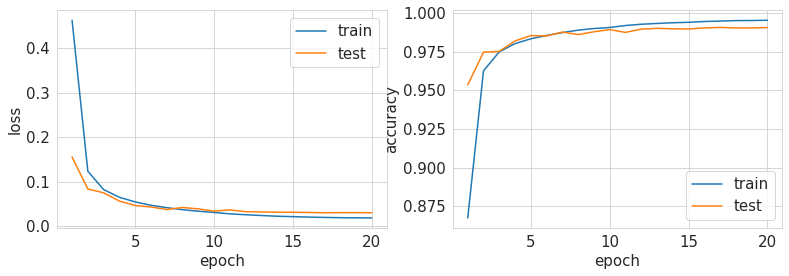

In [8]:
train()

In [14]:
transform = T.Compose([T.ToTensor(), T.Resize((32, 32))])
train_set = SVHN('SVHN', transform=None, split='train', download=True)
test_set = SVHN('SVHN', transform=None, split='test', download=True)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [17]:
img, label = train_set[0]
label

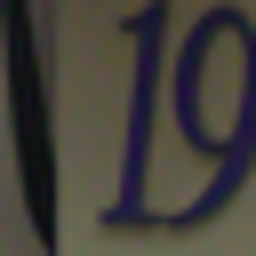

In [20]:
img.resize((256, 256))

In [24]:
train_set = SVHN('SVHN', transform=transform, split='train', download=True)
test_set = SVHN('SVHN', transform=transform, split='test', download=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Using downloaded and verified file: SVHN/train_32x32.mat
Using downloaded and verified file: SVHN/test_32x32.mat


In [25]:
NUM_EPOCHS = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LeNet(image_channels=3).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()

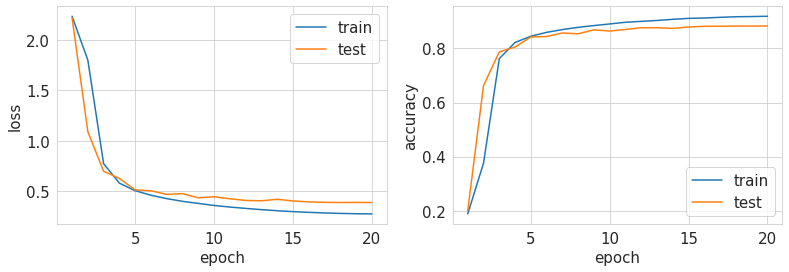

In [26]:
train()